In [1]:
from IPython import display

from matplotlib import pyplot as plt
%matplotlib inline

import math, itertools
import torch
from torch.optim import Adam
from torch.autograd import Variable
from torch.nn import functional, BCELoss
from torchvision import transforms, datasets

## Load Data

In [2]:
def mnist_data():
    compose = transforms.Compose(
        [transforms.ToTensor(),
         transforms.Normalize((.5, .5, .5), (.5, .5, .5))
        ])
    return datasets.MNIST(root='./data', train=True, transform=compose, download=True)

In [3]:
data = mnist_data()
batch_size = 100
data_loader = torch.utils.data.DataLoader(data, batch_size=batch_size, shuffle=True)

## Networks

In [4]:
class DiscriminativeNet(torch.nn.Module):
    """
    A two hidden-layer discriminative neural network
    """
    def __init__(self, n_features, n_hidden0, n_hidden1, n_hidden2):
        super(DiscriminativeNet, self).__init__()
        self.hidden0 = torch.nn.Linear(n_features, n_hidden0)
        self.hidden1 = torch.nn.Linear(n_hidden0, n_hidden1)
        self.hidden2 = torch.nn.Linear(n_hidden1, n_hidden2)
        self.out = torch.nn.Linear(n_hidden2, 1)

    def forward(self, x):
        x = torch.nn.LeakyReLU(0.2)(self.hidden0(x))
        x = torch.nn.Dropout(0.3)(x)
        x = torch.nn.LeakyReLU(0.2)(self.hidden1(x))
        x = torch.nn.Dropout(0.3)(x)
        x = torch.nn.LeakyReLU(0.2)(self.hidden2(x))
        x = torch.nn.Dropout(0.3)(x)
        x = torch.nn.Sigmoid()(self.out(x))
        return x

In [5]:
class GenerativeNet(torch.nn.Module):
    """
    A three hidden-layer generative neural network
    """
    def __init__(self, n_features, n_hidden0, n_hidden1, n_hidden2 , n_out):
        super(GenerativeNet, self).__init__()
        self.hidden0 = torch.nn.Linear(n_features, n_hidden0)
        self.hidden1 = torch.nn.Linear(n_hidden0, n_hidden1)
        self.hidden2 = torch.nn.Linear(n_hidden1, n_hidden2)
        self.out = torch.nn.Linear(n_hidden2, n_out)

    def forward(self, x):
        x = torch.nn.LeakyReLU(0.2)(self.hidden0(x))
        x = torch.nn.LeakyReLU(0.2)(self.hidden1(x))
        x = torch.nn.LeakyReLU(0.2)(self.hidden2(x))
        return torch.nn.Tanh()(self.out(x))
    
# Noise
def noise(size):
    return Variable(torch.randn(size, 100)).cuda()

In [6]:
discriminator = DiscriminativeNet(784, 1024, 512, 256).cuda()
generator = GenerativeNet(100, 256, 512, 1024, 784).cuda()

## Optimization

In [7]:
# Optimizers
d_optimizer = Adam(discriminator.parameters(), lr=0.0002)
g_optimizer = Adam(generator.parameters(), lr=0.0002)

# Loss function
loss = BCELoss()

# Number of steps to apply to the discriminator
d_steps = 1  # In Goodfellow et. al 2014 this variable is assigned to 1
# Number of epochs
num_epochs = 200

## Training

In [8]:
def real_data_target(size):
    data = Variable(torch.ones(size))
    return data.cuda()

def fake_data_target(size):
    data = Variable(torch.zeros(size))
    return data.cuda()

In [9]:
def train_discriminator(optimizer, real_data, fake_data):
    # Reset gradients
    optimizer.zero_grad()
    # 1.1 Train on Real Data
    prediction_real = discriminator(real_data)
#    raw_input('...')
    # Calculate error and backpropagate
    error_real = loss(prediction_real, real_data_target(real_data.size(0)))
    error_real.backward()

    # 1.2 Train on Fake Data
    prediction_fake = discriminator(fake_data)
    # Calculate error and backpropagate
    error_fake = loss(prediction_fake, fake_data_target(real_data.size(0)))
    error_fake.backward()
    # Update weights with gradients
    optimizer.step()
    # Return error
    return error_real + error_fake, prediction_real, prediction_fake

In [10]:
def train_generator(optimizer, fake_data):
    # 2. Train Generator
    # Reset gradients
    optimizer.zero_grad()
    # Sample noise and generate fake data
    prediction = discriminator(fake_data)
    # Calculate error and backpropagate
    error = loss(prediction, real_data_target(prediction.size()))
    error.backward()
    # Update weights with gradients
    optimizer.step()
    # Return error
    return error

In [ ]:
num_test_samples = 16
test_noise = Variable(torch.randn(num_test_samples, 100)).cuda()

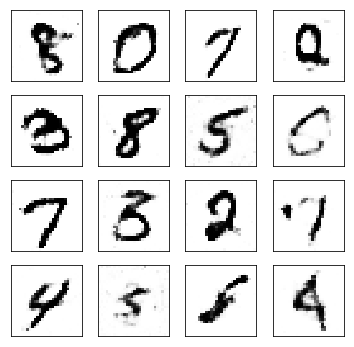

Epoch: [191/200], Batch Num: [500/600]
Discriminator Loss: 1.3287, Generator Loss: 0.8223
D(x): 0.5309, D(G(z)): 0.4688


In [ ]:
# create figure for plotting
size_figure_grid = int(math.sqrt(num_test_samples))
fig, ax = plt.subplots(size_figure_grid, size_figure_grid, figsize=(6, 6))
for i, j in itertools.product(range(size_figure_grid), range(size_figure_grid)):
    ax[i,j].get_xaxis().set_visible(False)
    ax[i,j].get_yaxis().set_visible(False)


for epoch in range(num_epochs):
    for n_batch, (real_batch,_) in enumerate(data_loader):

        # Train Discriminator
        real_data = Variable(real_batch.view(real_batch.size(0), 784)).cuda()
        fake_data = generator(noise(real_batch.size(0))).detach()
        d_error, d_pred_real, d_pred_fake = train_discriminator(d_optimizer, real_data, fake_data)

        # Train Generator
        fake_data = generator(noise(real_batch.size(0)))
        g_error = train_generator(g_optimizer, fake_data)

        # Print log
        if (n_batch) % 100 == 0:
            display.clear_output(True)
            test_images = generator(test_noise)
            for k in range(num_test_samples):
                i = k//4
                j = k%4
                ax[i,j].cla()
                ax[i,j].imshow(test_images[k,:].data.cpu().numpy().reshape(28, 28), cmap='Greys')
            display.display(plt.gcf())
            
            print('Epoch: [{}/{}], Batch Num: [{}/{}]'.format(epoch, num_epochs, n_batch, len(data_loader)))
            print('Discriminator Loss: {:.4f}, Generator Loss: {:.4f}'.format(d_error.data[0], g_error.data[0]))
            print('D(x): {:.4f}, D(G(z)): {:.4f}'.format(d_pred_real.data.mean(), d_pred_fake.data.mean()))